# Data analysis

The following dates are targeted:  22.04.22 and 24.04.24

In [70]:
# Import the libraries and helper functions
import functions

import glob
import os
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sunpy.coordinates import get_body_heliographic_stonyhurst
from sunpy.coordinates import frames
from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a

import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.wcs import WCS
from astropy.time import Time
from astropy.io import fits
from astropy.visualization import time_support

from skyfield.api import load

import astroquery.heasarc
from astroquery.heasarc import Heasarc, Conf

from datetime import datetime
from datetime import timedelta
import pytz

from scipy.optimize import minimize
from scipy.optimize import curve_fit

from sklearn import preprocessing

### Venus' position in the sky

In [2]:
def plot_venus_position(venus_times,venus_positions):
    plt.figure(figsize=(10,5))
    for this_time,this_position in zip(venus_times,venus_positions):
        plt.scatter(this_position.ra.to('deg'),this_position.dec.to('deg'),s=10,marker = 'o',color='red')
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.title('Venus position: {} to {}'.format(venus_times[0].utc_strftime('%Y-%m-%d'), venus_times[-1].utc_strftime('%Y-%m-%d')))
    plt.savefig('../figures/Venus_position.png',dpi=500)


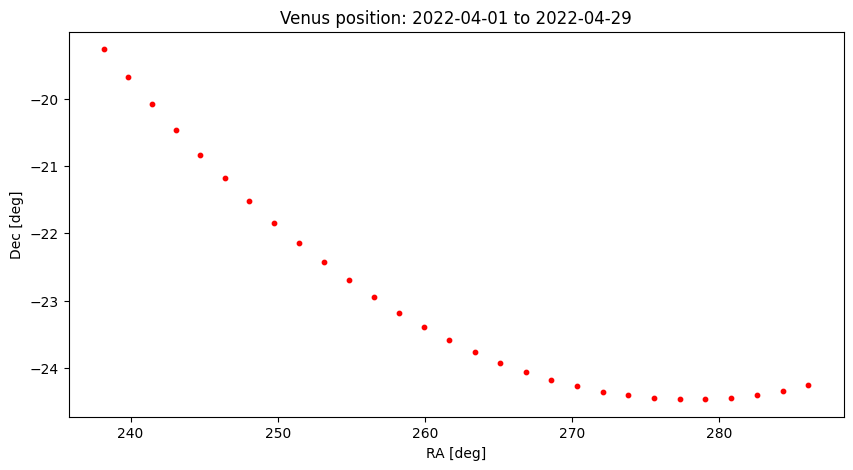

In [3]:
venus_times,venus_positions = functions.get_venus_position(2022,4,1,30,1)
plot_venus_position(venus_times,venus_positions)

### Retrieving corresponding scw

We'll work day by day

In [ ]:
# radius = '5 degree'
# for coord,time in zip(venus_positions,venus_times):
#     delta_time = time + 1
#     time = time.utc_strftime('%Y-%m-%dT%H:%M:%S')
#     delta_time = delta_time.utc_strftime('%Y-%m-%dT%H:%M:%S')
#     table = functions.get_scw_list(coord,radius,time,delta_time)
#     if not table:
#         continue
#     else:
#         table.write('scw/'+str(time.replace(':','_')) + '.fits',overwrite=True)

### Getting the data arrays

We'll assign the table variables to the corresponding dates. These table will contain the information on each scw for a given day.

Then we'll query the different scw to get the actual arrays from JEMX in a 3-10 keV range. Prepare your token. The data here is private.

In [4]:
table = astropy.table.Table.read('scw/2022-04-24T00_00_00.fits')
table_220422 = astropy.table.Table.read('scw/2022-04-22T00_00_00.fits')

In [5]:
token = functions.login()

In [ ]:
# functions.query_jemx_from_table(table, "3","10",token)
# functions.query_jemx_from_table(table_220422, "3","10",token)

Here are some remarkable sources in our data that are used to check that we are plotting correctly.

In [6]:
ginga_coord = SkyCoord('18h29m28.2s', '-23d47m49s', frame='icrs') # Ginga 1824 position
gx131_coord = SkyCoord('18h14m31.55s', '-17d09m26.7s', frame='icrs') # GX 131 position
gx51_coord = SkyCoord('18h01m9.73s', '-25d04m44.12s', frame='icrs') # GX 51 position

Now let's open the fits files and get the arrays.

In [7]:
directory_path = "data/2022-04-22T00_00_00"
fits_files = sorted(glob.glob(os.path.join(directory_path, "*.fits")))
fits_data_220422 = {}
for fits_file in fits_files:
    file_name = fits_file.split('\\')[-1]
    file_name = file_name.split('.')[0]  # get the file name with only the scw id.
    fits_data_220422[file_name] = fits.open(fits_file)

directory_path = "data/2022-04-24T00_00_00"
fits_files = sorted(glob.glob(os.path.join(directory_path, "*.fits")))
fits_data = {}
for fits_file in fits_files:
    file_name = fits_file.split('\\')[-1]
    file_name = file_name.split('.')[0]  # get the file name with only the scw id.
    fits_data[file_name] = fits.open(fits_file)

### Plotting the position of Venus on the fits, getting the coordinates of Venus, the fluxes etc...

In [23]:
def get_lc_jemx(table, fits_data, coord_list):

    from datetime import timedelta
    from datetime import datetime
    import math
    import numpy as np
    import pytz
    from astropy.wcs import WCS

    lc_times = []
    lc_fluxes = []
    lc_errors = []
    time_errors = []
    timezone = pytz.timezone('UTC')

    for scw,coord in zip(fits_data.keys(),coord_list):

        if scw == '249400300010' or scw =='249400350010' or scw =='249400360010':
            continue

        wcs = WCS(fits_data[str(scw)][2].header)
        row = table[table['SCW_ID'] == scw]
        t_start=str(row['START_DATE'][0].replace(' ','T'))
        t_end = str(row['END_DATE'][0].replace(' ','T'))
        delta_t = datetime.fromisoformat(t_end) - datetime.fromisoformat(t_start)
        x_start,y_start = wcs.wcs_world2pix(coord[0].ra.deg,coord[0].dec.deg,1)
        x_end,y_end = wcs.wcs_world2pix(coord[1].ra.deg,coord[1].dec.deg,1)
        flux_error = np.sqrt(fits_data[str(scw)][3].data[np.round(int(y_start)),int(np.round(x_start))])
        travel_x, travel_y = np.linspace(x_start,x_end,fits_data[str(scw)][2].data.shape[0]), np.linspace(y_start,y_end,fits_data[str(scw)][2].data.shape[0])
        flux_values = fits_data[str(scw)][2].data[np.round(travel_y).astype(int), np.round(travel_x).astype(int)]
        flux_values = [x for x in flux_values if not math.isnan(x)]
        unique_flux_values, counts = np.unique(flux_values, return_counts=True)
        flux_counter = dict(zip(unique_flux_values, counts))
        flux_times = []
        time_error = []
        lc_error = []
        #define the time erros as the time interval where the flux value is present
        total_time = datetime.strptime(t_start,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
        for flux in flux_counter.keys():
            #flux_times.append(total_time + timedelta(seconds=delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)/2)))
            flux_times.append(total_time + delta_t * (flux_counter[flux]/len(flux_values)/2))
            total_time = total_time + timedelta(seconds=delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)))
            time_error.append((delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)))/86400/2)
            lc_error.append(flux_error)

        lc_fluxes.append(unique_flux_values)
        lc_errors.append(lc_error)
        lc_times.append(flux_times)
        time_errors.append(time_error)

    return lc_times, lc_fluxes, lc_errors, time_errors

In [ ]:
# Conversion factor from arbirtary units to erg/cm2/s. The Crab is used as a reference.
#functions.query_jemx_from_scw('010200230010.001',3,10,token)
factor = 3.6e-10

22.04

In [9]:
# Compute Venus position for each file

# Load the JPL ephemeris DE421 (covers 1900-2050).
eph = load('de421.bsp')
venus = eph['venus']
coord_list_220422 = []
for scw in fits_data_220422.keys():
    row = table_220422[table_220422['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    ts = load.timescale()
    timezone = pytz.timezone('UTC')
    t_start = ts.utc(timezone.localize(datetime.fromisoformat(t_start)))
    t_end = ts.utc(timezone.localize(datetime.fromisoformat(t_end)))

    venus_pos_start = venus.at(t_start)
    ra, dec, distance = venus_pos_start.radec() 
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_start = SkyCoord(ra, dec, frame='icrs')
    venus_pos_end = venus.at(t_end)
    ra, dec, distance = venus_pos_end.radec()
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_end = SkyCoord(ra, dec, frame='icrs')
    coord_list_220422.append([c_start,c_end])

In [ ]:
# Plots
for scw,coord in zip(fits_data_220422.keys(),coord_list_220422):
    plt.figure(figsize=(10, 10))
    title_str = f"{scw} - Flux map"
    wcs = WCS(fits_data_220422[str(scw)][2].header)
    ax = plt.subplot(projection=wcs)
    ax.imshow(fits_data_220422[str(scw)][2].data, cmap='gray', interpolation=None, origin='lower')
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
    ax.plot_coord(coord[0], "o",markerfacecolor='none', markeredgecolor='w',markersize=10, label='Venus Start')
    ax.plot_coord(coord[1], "o",markerfacecolor='none', markeredgecolor='r',markersize=10, label='Venus End')
    ax.plot_coord(gx51_coord, "o",markerfacecolor='none', markeredgecolor='b',markersize=10, label='GX 5-1')
    #ax.plot_coord(gx131_coord, "o",markerfacecolor='none', markeredgecolor='g',markersize=10, label='GX 13+1')
    #ax.plot_coord(ginga_coord, "o",markerfacecolor='none', markeredgecolor='b',markersize=10, label='Ginga-1826-24')
    ax.legend(loc = 'upper center')
    ax.set_title(title_str)

In [24]:
# And plotting the LCs.
lc_times_220422, lc_fluxes_220422, lc_errors_220422, time_errors_220422 = get_lc_jemx(table_220422,fits_data_220422, coord_list_220422)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


In [25]:
unraveled_fluxes_22 = [item for sublist in lc_fluxes_220422 for item in sublist]
unraveled_errors_22 = [item for sublist in lc_errors_220422 for item in sublist]
mean_flux_22= sum([x/y/y for x,y in zip(unraveled_fluxes_22,unraveled_errors_22)])/sum([1/y/y for y in unraveled_errors_22])
mean_error_22 = np.sqrt(1/sum([1/y/y for y in unraveled_errors_22]))
unraveled_times_22 = [item for sublist in lc_times_220422 for item in sublist]
earliest_date_22 = datetime.fromisoformat(str(min(unraveled_times_22)))
latest_date_22 = datetime.fromisoformat(str(max(unraveled_times_22)))
date_array_22= np.linspace(0, 1, 10)
date_array_22 = [(latest_date_22 - earliest_date_22) * x + earliest_date_22 for x in date_array_22]
mean_flux_22 = mean_flux_22 * factor
mean_error_22 = mean_error_22 * factor

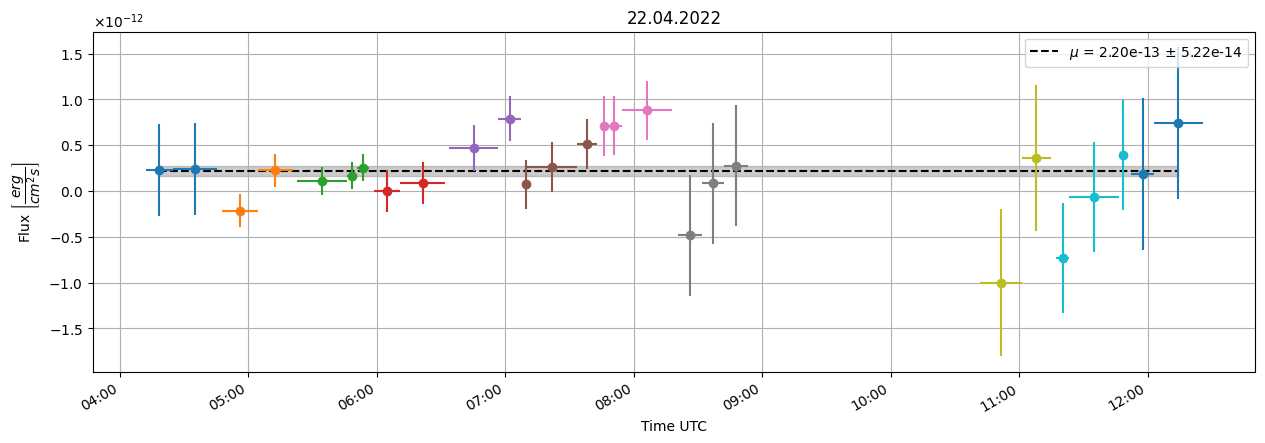

In [27]:
plt.figure(figsize=(15,5))
plt.gca().fill_between(date_array_22, mean_flux_22+mean_error_22, mean_flux_22-mean_error_22, color='gray', alpha=0.4)
plt.plot(date_array_22, mean_flux_22*np.ones(len(date_array_22)), color='black', linestyle='--',label=f'$\mu$ = {mean_flux_22:.2e} $\pm$ {mean_error_22:.2e}')
for i in range(len(lc_times_220422)):
    dates = matplotlib.dates.date2num(lc_times_220422[i])
    plt.errorbar(dates,factor * lc_fluxes_220422[i],yerr=[float(x)*factor for x in lc_errors_220422[i]],xerr=time_errors_220422[i],fmt='o')
plt.xlabel('Time UTC')
date_fmt = matplotlib.dates.DateFormatter('%H:%M')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gcf().autofmt_xdate()
# grid
plt.grid(True, which='both')
plt.ylabel(r'Flux $\left[\dfrac{erg}{cm^2 s}\right]$')
plt.title('22.04.2022')
plt.legend()
#plt.savefig('../figures/2204/lc_2204.png', dpi=500)

24.04

In [12]:
coord_list = []
for scw in fits_data.keys():
    row = table[table['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    ts = load.timescale()
    timezone = pytz.timezone('UTC')
    t_start = ts.utc(timezone.localize(datetime.fromisoformat(t_start)))
    t_end = ts.utc(timezone.localize(datetime.fromisoformat(t_end)))

    venus_pos_start = venus.at(t_start)
    ra, dec, distance = venus_pos_start.radec() 
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_start = SkyCoord(ra, dec, frame='icrs')
    venus_pos_end = venus.at(t_end)
    ra, dec, distance = venus_pos_end.radec()
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_end = SkyCoord(ra, dec, frame='icrs')
    coord_list.append([c_start,c_end])

In [ ]:
for scw,coord in zip(fits_data.keys(),coord_list):
    plt.figure(figsize=(10,10))
    title_str = f"{scw} - Flux map"
    wcs = WCS(fits_data[str(scw)][2].header)
    ax = plt.subplot(projection=wcs)
    ax.imshow(fits_data[str(scw)][2].data, cmap='gray', interpolation=None, origin='lower')
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
    ax.plot_coord(coord[0], "o",markerfacecolor='none', markeredgecolor='w',label='Venus Start',markersize=10)
    ax.plot_coord(coord[1], "o",markerfacecolor='none', markeredgecolor='r',label='Venus End',markersize=10)
    ax.plot_coord(ginga_coord, "o",markerfacecolor='none', markeredgecolor='b',label='Ginga-1826-24',markersize=10)
    ax.legend(loc='upper center')
    ax.set_title(title_str)

In [15]:
# Everything relevant for the light curve
lc_times = []
lc_fluxes = []
lc_errors = []
time_errors = []

for scw,coord in zip(fits_data.keys(),coord_list):

    wcs = WCS(fits_data[str(scw)][2].header)
    row = table[table['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    delta_t = datetime.fromisoformat(t_end) - datetime.fromisoformat(t_start)
    x_start,y_start = wcs.wcs_world2pix(coord[0].ra.deg,coord[0].dec.deg,1)
    x_end,y_end = wcs.wcs_world2pix(coord[1].ra.deg,coord[1].dec.deg,1)
    flux_error = np.sqrt(fits_data[str(scw)][3].data[np.round(int(y_start)),int(np.round(x_start))])
    sep_tot = coord[0].separation(coord[1])
    travel_x, travel_y = np.linspace(x_start,x_end,fits_data[str(scw)][2].data.shape[0]), np.linspace(y_start,y_end,fits_data[str(scw)][2].data.shape[0])
    flux_values = fits_data[str(scw)][2].data[np.round(travel_y).astype(int), np.round(travel_x).astype(int)]
    flux_values = [x for x in flux_values if not math.isnan(x)]
    unique_flux_values, counts = np.unique(flux_values, return_counts=True)
    flux_counter = dict(zip(unique_flux_values, counts))
    #print(delta_t)
    flux_times = []
    time_error = []
    lc_error = []
    #define the time erros as the time interval where the flux value is present
    total_time = datetime.strptime(t_start,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    for flux in flux_counter.keys():
        flux_times.append(total_time + delta_t * (flux_counter[flux]/len(flux_values)/2))
        total_time = total_time + timedelta(seconds=delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)))
        time_error.append((delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)))/86400/2)
        lc_error.append(flux_error)

    lc_fluxes.append(unique_flux_values)
    lc_errors.append(lc_error)
    lc_times.append(flux_times)
    time_errors.append(time_error)

In [16]:
unraveled_fluxes = [item for sublist in lc_fluxes for item in sublist]
unraveled_errors = [item for sublist in lc_errors for item in sublist]

In [17]:
#let's plot the weighted average of the flux
mean_flux = sum([x/y/y for x,y in zip(unraveled_fluxes,unraveled_errors)])/sum([1/y/y for y in unraveled_errors])
mean_error = np.sqrt(1/sum([1/y/y for y in unraveled_errors]))
#find earliest date:
unraveled_times = [item for sublist in lc_times for item in sublist]
earliest_date = datetime.fromisoformat(str(min(unraveled_times)))
latest_date = datetime.fromisoformat(str(max(unraveled_times)))
# create a linearly spaced array of dates
date_array = np.linspace(0, 1, 10)
date_array = [(latest_date - earliest_date) * x + earliest_date for x in date_array]

In [ ]:
mean_flux = mean_flux * factor
mean_error = mean_error * factor

And plotting the LC.

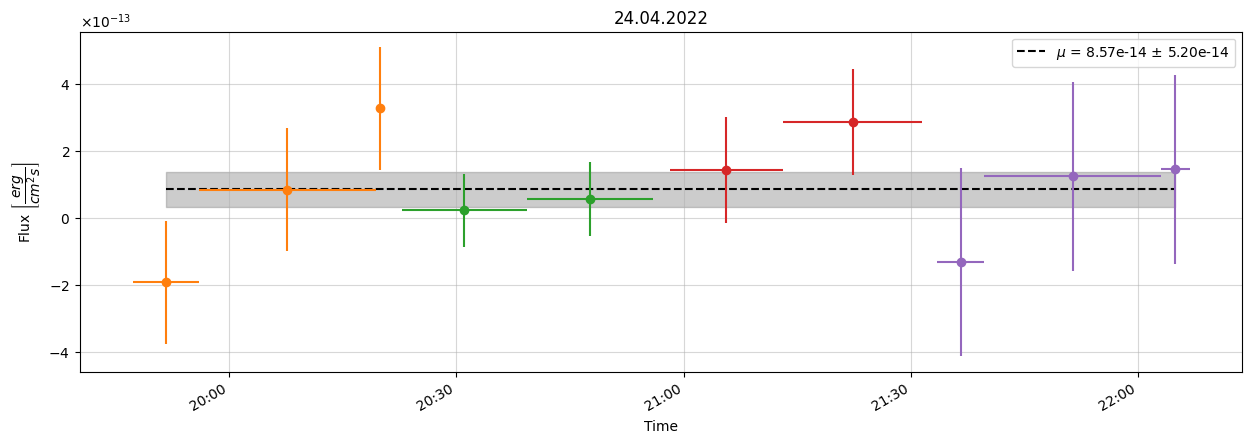

In [22]:
plt.figure(figsize=(15,5))
plt.gca().fill_between(date_array, mean_flux+mean_error, mean_flux-mean_error, color='gray', alpha=0.4)
plt.plot(date_array, mean_flux*np.ones(len(date_array)), color='black', linestyle='--',label=f'$\mu$ = {mean_flux:.2e} $\pm$ {mean_error:.2e}')
for i in range(len(lc_times)):
    dates = matplotlib.dates.date2num(lc_times[i])
    plt.errorbar(dates,factor * lc_fluxes[i],yerr=[float(x)*factor for x in lc_errors[i]],xerr=time_errors[i],fmt='o')
plt.xlabel('Time')
date_fmt = matplotlib.dates.DateFormatter('%H:%M')
plt.title('24.04.2022')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gcf().autofmt_xdate()
#grid
plt.grid(True,which='both',alpha=0.5)
plt.ylabel(r'Flux $\left[\dfrac{erg}{cm^2 s}\right]$')
plt.legend()
#plt.savefig('../figures/2404/lc_2404.png',dpi=500)

### Using PSF modelling to get the fluxes in a different way.

Two approaches:

1. Assume flux of Venus not constant in the SCW.
2. Assume flux of Venus is constant in the SCW.

In both cases, the PSF is modeled by a sum of two 2D Gaussians centered on the initial and final positions of Venus in the image.

In [29]:
def sum_gaussian_2d(xy, offset, h1, h2, xo1, yo1, xo2, yo2):
    x, y = xy
    exponent1 = -((x - xo1)**2 / (2 * 0.82**2) + (y - yo1)**2 / (2 * 0.82**2))
    exponent2 = -((x - xo2)**2 / (2 * 0.82**2) + (y - yo2)**2 / (2 * 0.82**2))
    g= offset + h1 * np.exp(exponent1) + h2 * np.exp(exponent2)
    return g.ravel()

def objective(params,xy,data,xo1,yo1,xo2,yo2):
    offset, h1, h2 = params
    model = sum_gaussian_2d(xy,offset, h1, h2, xo1, yo1, xo2, yo2)
    error = np.sum((data - model)**2)
    return error
def sum_gaussian_2d_const(xy, offset, h, xo1, yo1, xo2, yo2):
    x, y = xy
    exponent1 = -((x - xo1)**2 / (2 * 0.82**2) + (y - yo1)**2 / (2 * 0.82**2))
    exponent2 = -((x - xo2)**2 / (2 * 0.82**2) + (y - yo2)**2 / (2 * 0.82**2))
    g= offset + h * np.exp(exponent1) + h * np.exp(exponent2)
    return g.ravel()

def objective_const(params,xy,data,xo1,yo1,xo2,yo2):
    offset, h = params
    model = sum_gaussian_2d_const(xy,offset, h, xo1, yo1, xo2, yo2)
    error = np.sum((data - model)**2)
    return error
def dev_fit(x,a,b,c):# for the uncertainty of the fit, we will assume a quadratic function and set the threshold once the deviations differ by more than 2%
    return a*x**2+b*x+c

#### 22.04 Non constant flux

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


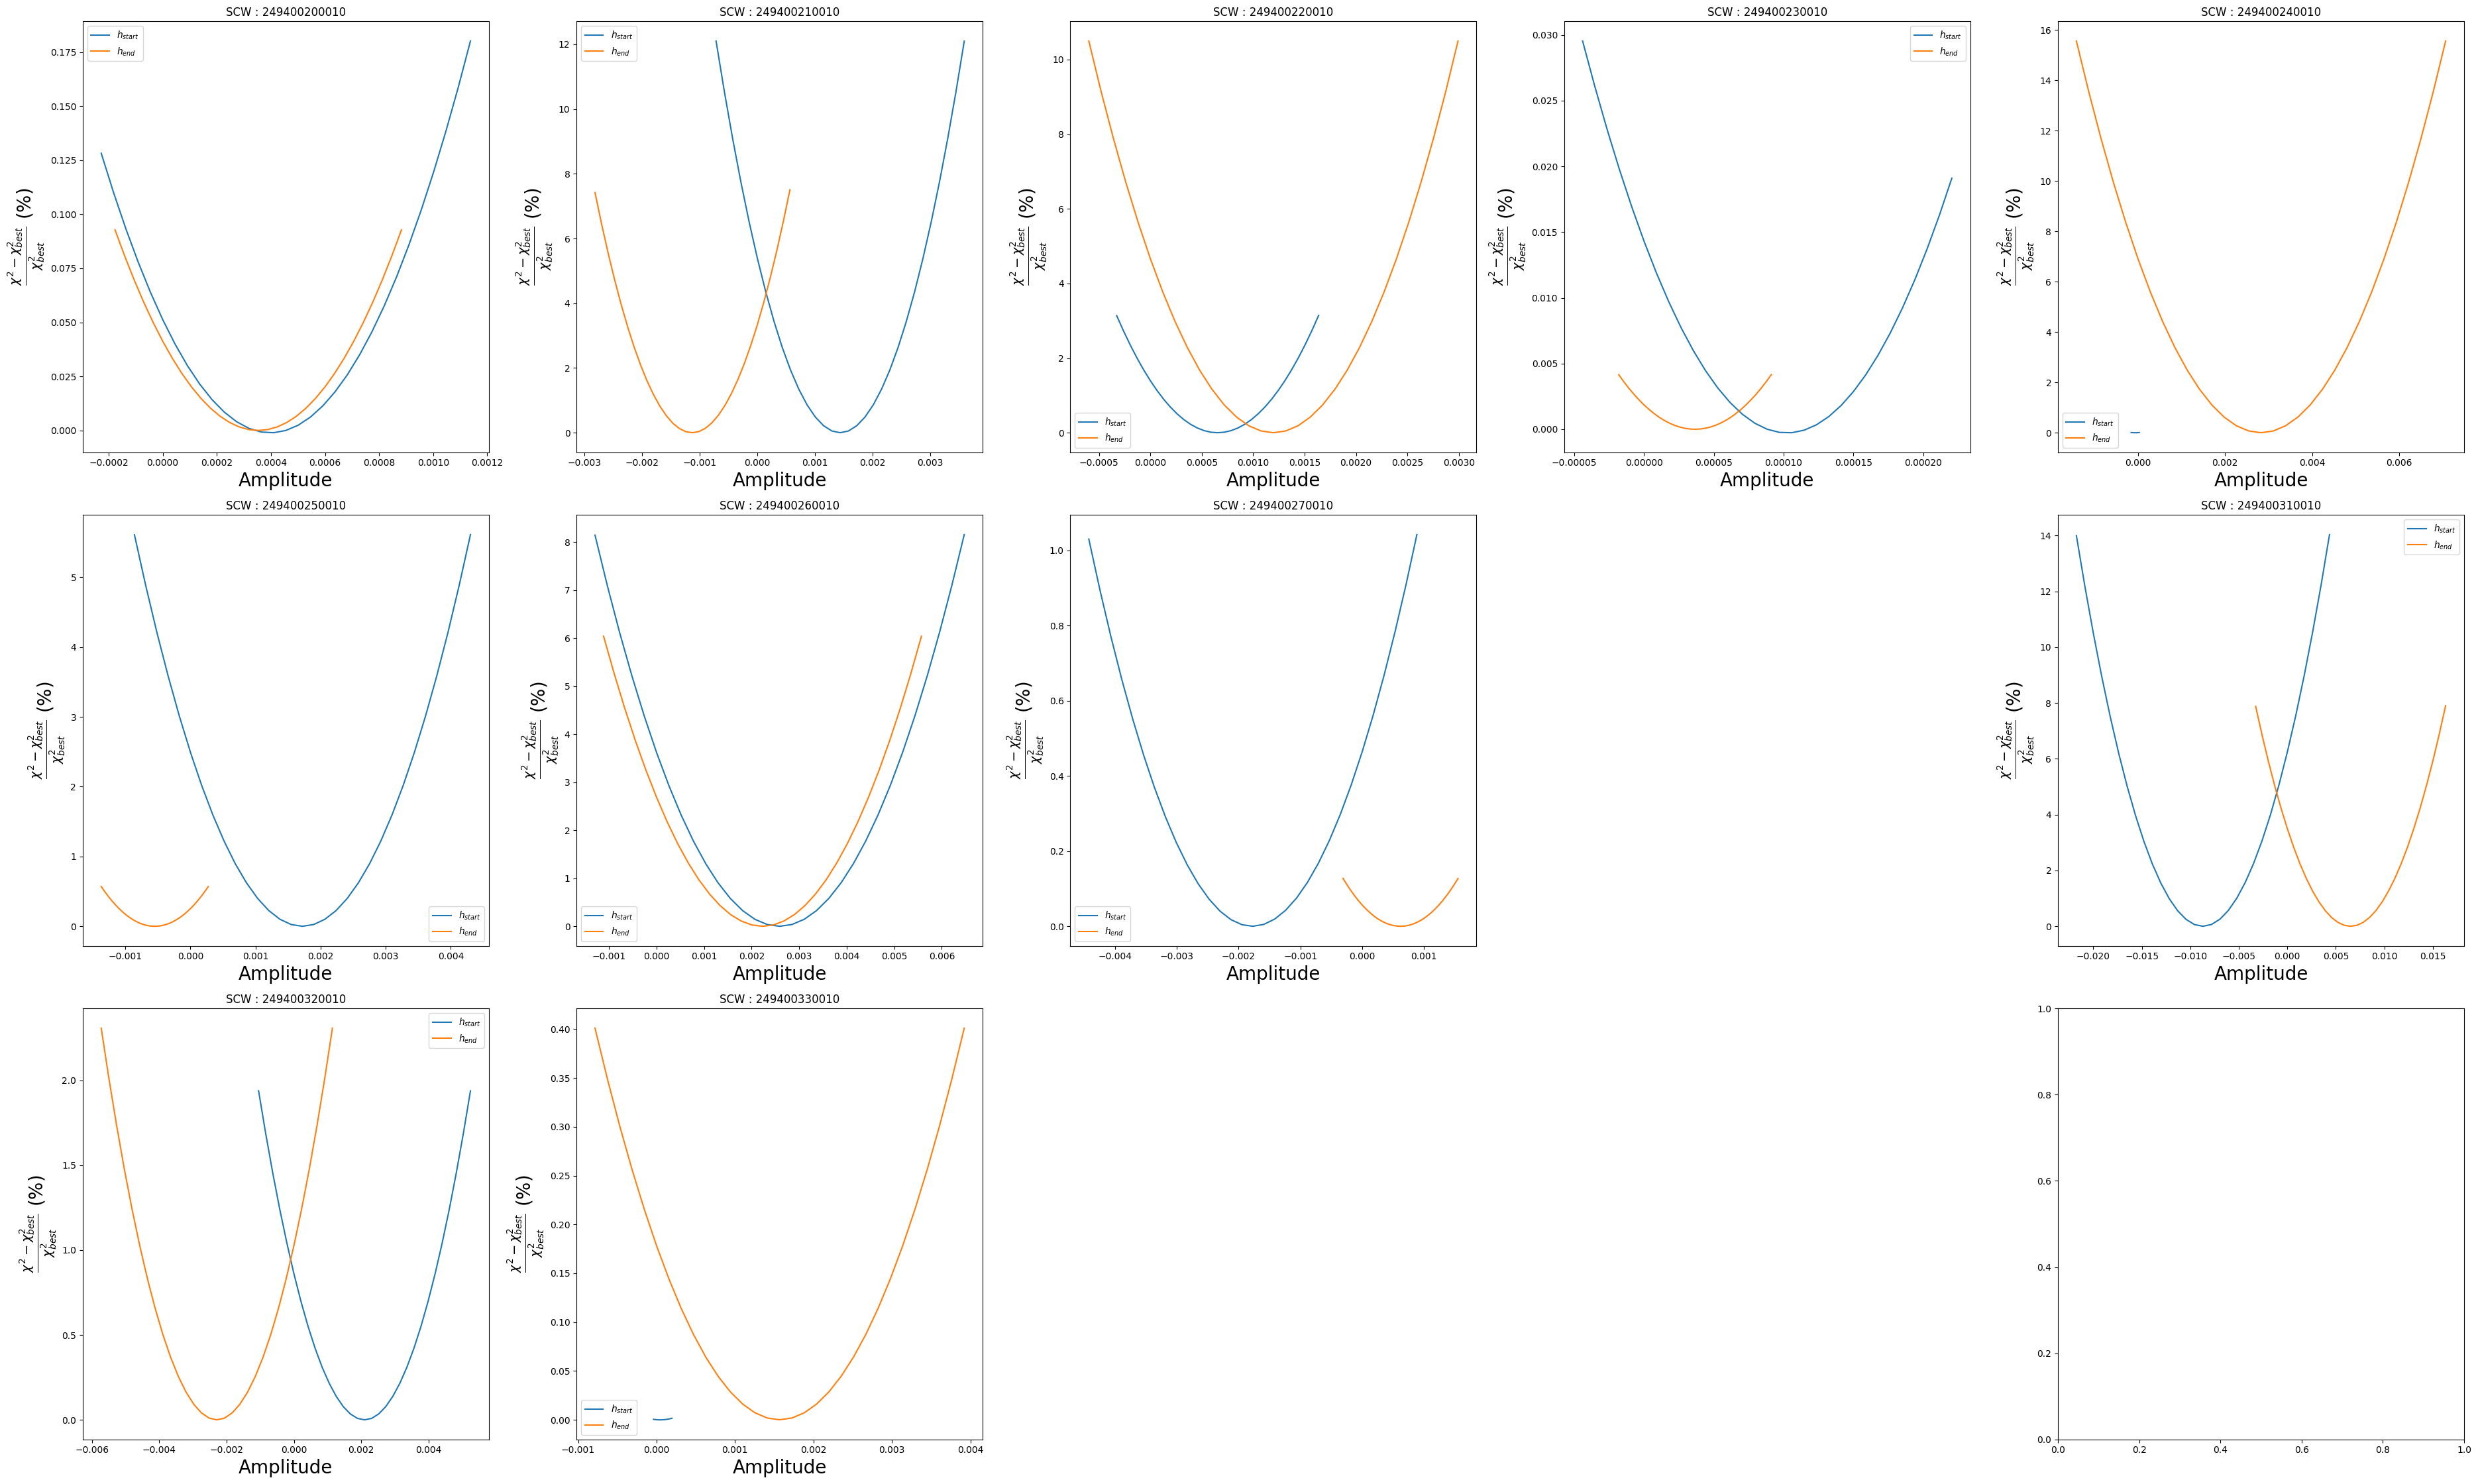

In [31]:
opti_flux_22 = []
opti_times_22 = []
opti_errors_22 = []
threshold = 2
figure,axes = plt.subplots(3,int(np.round((len(coord_list_220422))/3)),figsize=(7.5*int(np.round((len(coord_list_220422))/3)),22.5))
axes = axes.flatten()
for index, (scw_test, coord_test) in enumerate(zip(fits_data_220422.keys(), coord_list_220422)):
    ax1 = axes[index]
    if scw_test == '249400300010' or scw_test =='249400350010' or scw_test =='249400360010':
        #ax1.text(0.5, 0.5, 'NO DATA', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
        axes[index].remove()
        continue
    wcs = WCS(fits_data_220422[str(scw_test)][2].header)
    row = table_220422[table_220422['SCW_ID'] == scw_test]

    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_start = datetime.strptime(t_start,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    t_end = datetime.strptime(t_end,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    flux_times =[t_start, t_end]
    opti_times_22.append(flux_times)

    data_test = fits_data_220422[str(scw_test)][2].data
    x_start,y_start = wcs.wcs_world2pix(coord_test[0].ra.deg,coord_test[0].dec.deg,1)
    x_end,y_end = wcs.wcs_world2pix(coord_test[1].ra.deg,coord_test[1].dec.deg,1)
    x_start,x_end,y_start,y_end = int(np.round(x_start)),int(np.round(x_end)),int(np.round(y_start)),int(np.round(y_end))
    delta = 10
    data_test = data_test[y_start-delta:y_start+delta,x_start-delta:x_start+delta] #we take a square of 20x20 pixels around the source initial position
    data_test = np.nan_to_num(data_test)
    if np.sum(data_test) != 0:
        x_data= np.arange(data_test.shape[1])
        y_data = np.arange(data_test.shape[0])

        x_data, y_data = np.meshgrid(x_data, y_data)
        z_data = data_test.flatten()

        #initial guess at center of image
        initial_guess = (0, 1e-4, 1e-4)

        # Fit the Gaussian to the data with fixed centers
        result = minimize(objective,initial_guess, args=((x_data,y_data), z_data, x_data.shape[0]/2, y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)),method='Powell')
        offset,h1,h2 = result.x
        fit = sum_gaussian_2d((x_data, y_data), offset,h1,h2,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)).reshape(data_test.shape)
        residual = data_test - fit
        x,y = np.meshgrid(np.linspace(0,20,100),np.linspace(0,20,100))
        fit_smooth = sum_gaussian_2d((x, y), offset,h1,h2,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)).reshape(x.shape)

        opti_flux_22.append(np.array([h1,h2]))

        h = np.array([h1,h2])
        opti_error = []
        for i in range(len(h)):
            best_fit = h[i]
            amplitude_range = 3*best_fit
            num_steps = 31
            amplitude_values = np.linspace(best_fit-amplitude_range/2,best_fit+amplitude_range/2,num_steps)
            chi_square_values = np.zeros_like(amplitude_values)
            for k, amplitude in enumerate(amplitude_values):
            # Fit the model with the fixed amplitude
            # Calculate the residuals between the model predictions and observed data
            # Calculate the chi-square value
                if i == 0:
                    model_fit = sum_gaussian_2d((x_data,y_data), offset, amplitude,h[1],x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start))
                else:
                    model_fit = sum_gaussian_2d((x_data,y_data), offset,h[0],amplitude,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start))
                residuals = data_test.ravel() - model_fit
                chi_square = np.sum(residuals**2)
                chi_square_values[k] = chi_square
            best_fit_chi_square = np.sum(residual**2)
            deviations = (chi_square_values - best_fit_chi_square)/best_fit_chi_square*100

            if i == 0:
                ax1.plot(amplitude_values,deviations,label=r'$h_{start}$')
            else:
                ax1.plot(amplitude_values,deviations,label=r'$h_{end}$')
            ax1.set_xlabel('Amplitude',fontsize=20)
            ax1.set_ylabel(r'$\frac{\chi^2-\chi^2_{best}}{\chi^2_{best}}$ (%)',fontsize=20)
            ax1.legend()
            ax1.set_title('SCW : '+str(scw_test))
            popt, pcov = curve_fit(dev_fit, amplitude_values, deviations)
            amp = np.linspace(-0.02,0.02,10000)
            dev = dev_fit(amp,*popt)

            #find for which amp, we cross the 2% threshold
            for j in range(len(dev)):
                if dev[j] < threshold:
                    amplitude_uncertainty = np.abs(amp[j]-best_fit)
                    break
            opti_error.append(amplitude_uncertainty)

        opti_errors_22.append(opti_error)

        # fig,ax = plt.subplots(1,2,figsize=(14,7))
        # # Title for the figure
        # fig.suptitle('SCW : '+str(scw_test))
        # im1=ax[0].imshow(data_test, cmap='viridis')
        # im1b=ax[0].contour(fit, levels = 3,colors='black')
        # # Create Line2D objects for the legend
        # legend_elements = [
        #     Line2D([0], [0], color='black', label=r'Fit'),
        # ]
        # ax[0].legend(handles=legend_elements)
        # im2=ax[1].imshow(fit_smooth, cmap='viridis')
        # ax[0].set_title('Data')
        # ax[1].set_title('Model')
        # cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.04, pad=0.04)
        # cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.04, pad=0.04)
        # plt.tight_layout()
        # plt.show()
plt.tight_layout()
plt.show()

In [33]:
opti_flux_22_ur = np.array([item for sublist in opti_flux_22 for item in sublist])
opti_errors_22_ur = np.array([item for sublist in opti_errors_22 for item in sublist])
opti_mean_flux_22= sum([x/y/y for x,y in zip(opti_flux_22_ur,opti_errors_22_ur)])/sum([1/y/y for y in opti_errors_22_ur])
opti_mean_error_22 = np.sqrt(1/sum([1/y/y for y in opti_errors_22_ur]))
opti_times_22_ur = [item for sublist in opti_times_22 for item in sublist]
earliest_date_22 = datetime.fromisoformat(str(min(opti_times_22_ur)))
latest_date_22 = datetime.fromisoformat(str(max(opti_times_22_ur)))
date_array_22= np.linspace(0, 1, 10)
date_array_22 = [(latest_date_22 - earliest_date_22) * x + earliest_date_22 for x in date_array_22]
opti_mean_flux_22 = opti_mean_flux_22 * factor
opti_mean_error_22 = opti_mean_error_22 * factor

weighted_mean = sum(opti_flux_22_ur / opti_errors_22_ur**2) / sum(1 / opti_errors_22_ur**2)
weighted_error = np.sqrt(1 / sum(1 / opti_errors_22_ur**2))

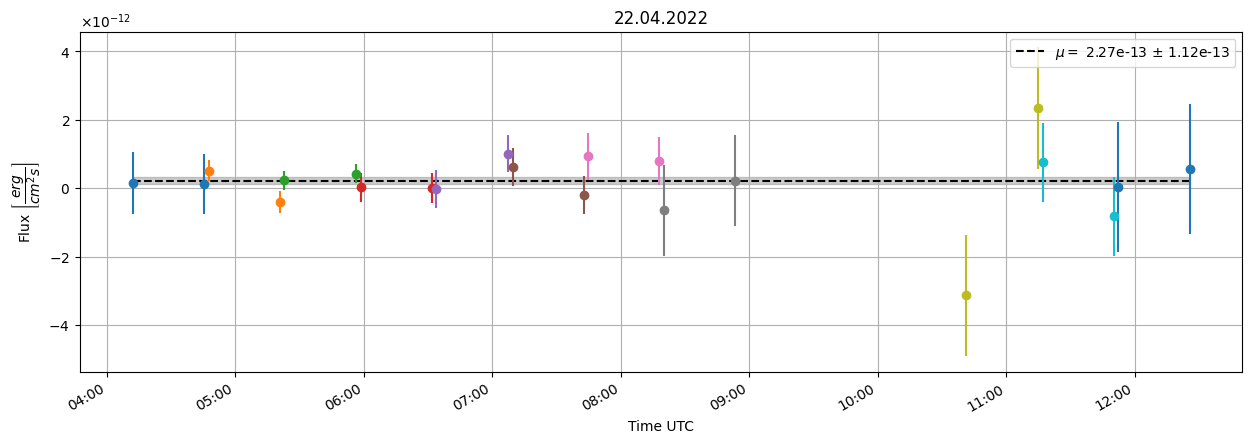

In [36]:
import matplotlib.ticker as ticker
plt.figure(figsize=(15,5))
plt.gca().fill_between(date_array_22, opti_mean_flux_22+opti_mean_error_22, opti_mean_flux_22-opti_mean_error_22, color='gray', alpha=0.4)
plt.plot(date_array_22, opti_mean_flux_22*np.ones(len(date_array_22)), color='black', linestyle='--',label=r'$\mu =$ {:.2e} $\pm$ {:.2e}'.format(opti_mean_flux_22, opti_mean_error_22))
for i in range(len(opti_times_22)):
    dates = matplotlib.dates.date2num(opti_times_22[i])
    plt.errorbar(dates,factor * opti_flux_22[i],yerr=[float(x)*factor for x in opti_errors_22[i]],fmt='o')
plt.xlabel('Time UTC')
date_fmt = matplotlib.dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gcf().autofmt_xdate()
#grid
plt.grid(True,which='both')
plt.ylabel(r'Flux $\left[\dfrac{erg}{cm^2 s}\right]$')
plt.title(r'22.04.2022')
plt.legend()
#plt.savefig('../figures/2204/lc_2204_psf_notconst.png',dpi=500)

#### 22.04 constant flux

In [37]:
opti_flux_22 = []
opti_times_22 = []
opti_errors_22 = []

for scw_test,coord_test in zip(fits_data_220422.keys(),coord_list_220422):

    if scw_test == '249400300010' or scw_test =='249400350010' or scw_test =='249400360010':
        continue
    wcs = WCS(fits_data_220422[str(scw_test)][2].header)
    row = table_220422[table_220422['SCW_ID'] == scw_test]

    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_start = datetime.strptime(t_start,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    t_end = datetime.strptime(t_end,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    flux_times =[t_start, t_end]
    opti_times_22.append(flux_times)

    data_test = fits_data_220422[str(scw_test)][2].data
    x_start,y_start = wcs.wcs_world2pix(coord_test[0].ra.deg,coord_test[0].dec.deg,1)
    x_end,y_end = wcs.wcs_world2pix(coord_test[1].ra.deg,coord_test[1].dec.deg,1)
    x_start,x_end,y_start,y_end = int(np.round(x_start)),int(np.round(x_end)),int(np.round(y_start)),int(np.round(y_end))
    delta = 10
    data_test = data_test[y_start-delta:y_start+delta,x_start-delta:x_start+delta] #we take a square of 20x20 pixels around the source initial position
    data_test = np.nan_to_num(data_test)
    if np.sum(data_test) != 0:
        x_data= np.arange(data_test.shape[1])
        y_data = np.arange(data_test.shape[0])

        x_data, y_data = np.meshgrid(x_data, y_data)
        z_data = data_test.flatten()

        #initial guess at center of image
        initial_guess = (0, 1e-4)

        # Fit the Gaussian to the data with fixed centers
        result = minimize(objective_const,initial_guess, args=((x_data,y_data), z_data, x_data.shape[0]/2, y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)))
        offset,h = result.x
        fit = sum_gaussian_2d_const((x_data, y_data), offset,h,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)).reshape(data_test.shape)
        residual = data_test - fit
        x,y = np.meshgrid(np.linspace(0,20,100),np.linspace(0,20,100))
        fit_smooth = sum_gaussian_2d_const((x, y), offset,h,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)).reshape(x.shape)

        opti_flux_22.append(np.array([h,h]))

        h_const = np.array([h])
        opti_error = []
        for i in range(len(h_const)):
            best_fit = h_const[i]
            amplitude_range = 1.5*best_fit
            num_steps = 11
            amplitude_values = np.linspace(best_fit-amplitude_range/2,best_fit+amplitude_range/2,num_steps)
            chi_square_values = np.zeros_like(amplitude_values)
            for k, amplitude in enumerate(amplitude_values):
            # Fit the model with the fixed amplitude
            # Calculate the residuals between the model predictions and observed data
            # Calculate the chi-square value
                model_fit = sum_gaussian_2d_const((x_data,y_data), offset, amplitude,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start))
                residuals = data_test.ravel() - model_fit
                chi_square = np.sum(residuals**2)
                chi_square_values[k] = chi_square
            best_fit_chi_square = np.sum(residual**2)
            deviations = (chi_square_values - best_fit_chi_square)/best_fit_chi_square*100
            popt, pcov = curve_fit(dev_fit, amplitude_values, deviations)
            amp = np.linspace(-0.02,0.02,10000)
            dev = dev_fit(amp,*popt)

            #find for which amp, we cross the 2% threshold
            for j in range(len(dev)):
                if dev[j] < threshold:
                    amplitude_uncertainty = np.abs(amp[j]-best_fit)
                    break
            opti_error.append(amplitude_uncertainty)

        opti_errors_22.append(opti_error)

        # fig,ax = plt.subplots(1,2,figsize=(14,7))
        # # Title for the figure
        # fig.suptitle('SCW : '+str(scw_test))
        # im1=ax[0].imshow(data_test, cmap='viridis')
        # im1b=ax[0].contour(fit, levels = 3,colors='black')
        # # Create Line2D objects for the legend
        # legend_elements = [
        #     Line2D([0], [0], color='black', label=r'Fit'),
        # ]
        # ax[0].legend(handles=legend_elements)
        # im2=ax[1].imshow(fit_smooth, cmap='viridis')
        # ax[0].set_title('Data')
        # ax[1].set_title('Model')
        # cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.04, pad=0.04)
        # cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.04, pad=0.04)
        # plt.tight_layout()
        # plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


In [38]:
opti_flux_22_ur = np.array([item for sublist in opti_flux_22 for item in sublist])
opti_errors_22_ur = np.array([item for sublist in opti_errors_22 for item in sublist])
opti_mean_flux_22= sum([x/y/y for x,y in zip(opti_flux_22_ur,opti_errors_22_ur)])/sum([1/y/y for y in opti_errors_22_ur])
opti_mean_error_22 = np.sqrt(1/sum([1/y/y for y in opti_errors_22_ur]))
opti_times_22_ur = [item for sublist in opti_times_22 for item in sublist]
earliest_date_22 = datetime.fromisoformat(str(min(opti_times_22_ur)))
latest_date_22 = datetime.fromisoformat(str(max(opti_times_22_ur)))
date_array_22= np.linspace(0, 1, 10)
date_array_22 = [(latest_date_22 - earliest_date_22) * x + earliest_date_22 for x in date_array_22]
opti_mean_flux_22 = opti_mean_flux_22 * factor
opti_mean_error_22 = opti_mean_error_22 * factor

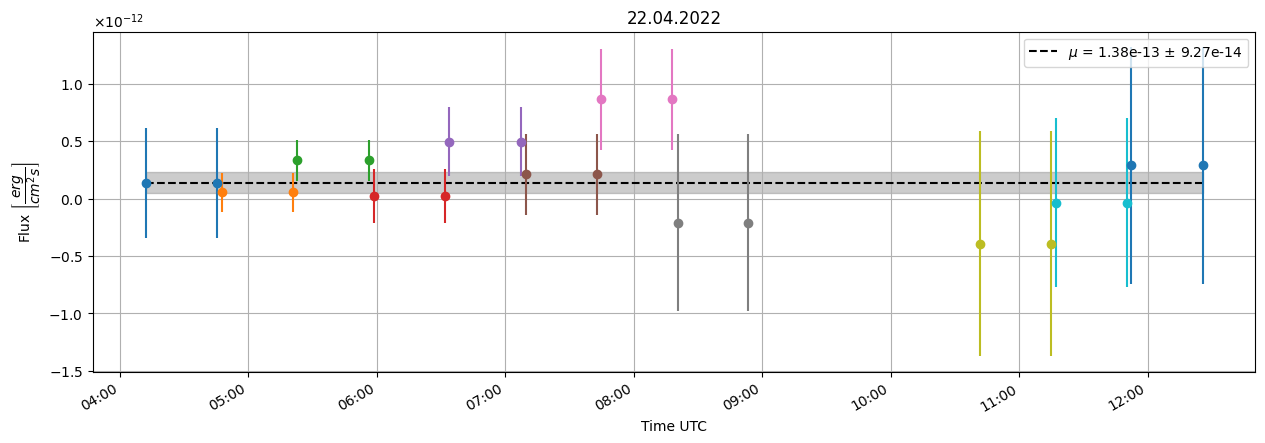

In [42]:
plt.figure(figsize=(15,5))
plt.gca().fill_between(date_array_22, opti_mean_flux_22+opti_mean_error_22, opti_mean_flux_22-opti_mean_error_22, color='gray', alpha=0.4)
plt.plot(date_array_22, opti_mean_flux_22*np.ones(len(date_array_22)), color='black', linestyle='--',label=f'$\mu$ = {opti_mean_flux_22:.2e} $\pm$ {opti_mean_error_22:.2e}')
for i in range(len(opti_times_22)):
    dates = matplotlib.dates.date2num(opti_times_22[i])
    plt.errorbar(dates,factor * opti_flux_22[i],yerr=[float(x)*factor for x in opti_errors_22[i]],fmt='o')
plt.xlabel('Time UTC')
date_fmt = matplotlib.dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gcf().autofmt_xdate()
#grid
plt.grid(True,which='both')
plt.ylabel(r'Flux $\left[\dfrac{erg}{cm^2 s}\right]$')
plt.title('22.04.2022')
plt.legend()
#plt.savefig('../figures/2204/lc_2204_psf_const.png',dpi=500)

#### 24.04 Non constant flux

In [43]:
opti_flux = []
opti_times = []
opti_errors = []

for scw_test,coord_test in zip(fits_data.keys(),coord_list):

    wcs = WCS(fits_data[str(scw_test)][2].header)
    row = table[table['SCW_ID'] == scw_test]

    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_start = datetime.strptime(t_start,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    t_end = datetime.strptime(t_end,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    flux_times =[t_start, t_end]

    data_test = fits_data[str(scw_test)][2].data
    x_start,y_start = wcs.wcs_world2pix(coord_test[0].ra.deg,coord_test[0].dec.deg,1)
    x_end,y_end = wcs.wcs_world2pix(coord_test[1].ra.deg,coord_test[1].dec.deg,1)
    x_start,x_end,y_start,y_end = int(np.round(x_start)),int(np.round(x_end)),int(np.round(y_start)),int(np.round(y_end))
    delta = 10
    data_test = data_test[y_start-delta:y_start+delta,x_start-delta:x_start+delta] #we take a square of 20x20 pixels around the source initial position
    data_test = np.nan_to_num(data_test)
    if np.sum(data_test) != 0:
        opti_times.append(flux_times)
        x_data= np.arange(data_test.shape[1])
        y_data = np.arange(data_test.shape[0])

        x_data, y_data = np.meshgrid(x_data, y_data)
        z_data = data_test.flatten()

        #initial guess at center of image
        initial_guess = (0, 1e-4, 1e-4)

        # Fit the Gaussian to the data with fixed centers
        result = minimize(objective,initial_guess, args=((x_data,y_data), z_data, x_data.shape[0]/2, y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)),method='Powell')
        offset,h1,h2 = result.x
        fit = sum_gaussian_2d((x_data, y_data), offset,h1,h2,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)).reshape(data_test.shape)
        residual = data_test - fit
        x,y = np.meshgrid(np.linspace(0,20,100),np.linspace(0,20,100))
        fit_smooth = sum_gaussian_2d((x, y), offset,h1,h2,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)).reshape(x.shape)

        opti_flux.append(np.array([h1,h2]))

        h = np.array([h1,h2])
        opti_error = []
        for i in range(len(h)):
            best_fit = h[i]
            amplitude_range = best_fit
            num_steps = 11
            amplitude_values = np.linspace(best_fit-amplitude_range/2,best_fit+amplitude_range/2,num_steps)
            chi_square_values = np.zeros_like(amplitude_values)
            for k, amplitude in enumerate(amplitude_values):
            # Fit the model with the fixed amplitude
            # Calculate the residuals between the model predictions and observed data
            # Calculate the chi-square value
                if i == 0:
                    model_fit = sum_gaussian_2d((x_data,y_data), offset, amplitude,h[1],x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start))
                else:
                    model_fit = sum_gaussian_2d((x_data,y_data), offset,h[0],amplitude,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start))
                residuals = data_test.ravel() - model_fit
                chi_square = np.sum(residuals**2)
                chi_square_values[k] = chi_square
            best_fit_chi_square = np.sum(residual**2)
            deviations = (chi_square_values - best_fit_chi_square)/best_fit_chi_square*100
            popt, pcov = curve_fit(dev_fit, amplitude_values, deviations)
            amp = np.linspace(-0.02,0.02,10000)
            dev = dev_fit(amp,*popt)

            #find for which amp, we cross the 2% threshold
            for j in range(len(dev)):
                if dev[j] < threshold:
                    amplitude_uncertainty = np.abs(amp[j]-best_fit)
                    break
            opti_error.append(amplitude_uncertainty)

        opti_errors.append(opti_error)

        # fig,ax = plt.subplots(1,2,figsize=(14,7))
        # # Title for the figure
        # fig.suptitle('SCW : '+str(scw_test))
        # im1=ax[0].imshow(data_test, cmap='viridis')
        # im1b=ax[0].contour(fit, levels = 3,colors='black')
        # # Create Line2D objects for the legend
        # legend_elements = [
        #     Line2D([0], [0], color='black', label=r'Fit'),
        # ]
        # ax[0].legend(handles=legend_elements)
        # im2=ax[1].imshow(fit_smooth, cmap='viridis')
        # ax[0].set_title('Data')
        # ax[1].set_title('Model')
        # cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.04, pad=0.04)
        # cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.04, pad=0.04)
        # plt.tight_layout()
        # plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


In [44]:
opti_flux_ur = np.array([item for sublist in opti_flux for item in sublist])
opti_errors_ur = np.array([item for sublist in opti_errors for item in sublist])
opti_mean_flux= sum([x/y/y for x,y in zip(opti_flux_ur,opti_errors_ur)])/sum([1/y/y for y in opti_errors_ur])
opti_mean_error = np.sqrt(1/sum([1/y/y for y in opti_errors_ur]))
opti_times_ur = [item for sublist in opti_times for item in sublist]
earliest_date = datetime.fromisoformat(str(min(opti_times_ur)))
latest_date = datetime.fromisoformat(str(max(opti_times_ur)))
date_array= np.linspace(0, 1, 10)
date_array = [(latest_date - earliest_date) * x + earliest_date for x in date_array]
opti_mean_flux = opti_mean_flux * factor
opti_mean_error = opti_mean_error * factor

weighted_mean = sum(opti_flux_ur / opti_errors_ur**2) / sum(1 / opti_errors_ur**2)
weighted_error = np.sqrt(1 / sum(1 / opti_errors_ur**2))

[[datetime.datetime(2022, 4, 24, 19, 47, 17, tzinfo=<UTC>), datetime.datetime(2022, 4, 24, 20, 20, 27, tzinfo=<UTC>)], [datetime.datetime(2022, 4, 24, 20, 22, 48, tzinfo=<UTC>), datetime.datetime(2022, 4, 24, 20, 55, 58, tzinfo=<UTC>)], [datetime.datetime(2022, 4, 24, 20, 58, 10, tzinfo=<UTC>), datetime.datetime(2022, 4, 24, 21, 31, 29, tzinfo=<UTC>)], [datetime.datetime(2022, 4, 24, 21, 33, 27, tzinfo=<UTC>), datetime.datetime(2022, 4, 24, 22, 6, 47, tzinfo=<UTC>)]] 
 [array([-0.00042054,  0.00133032]), array([-7.44145599e-05,  3.25114740e-04]), array([-5.99838648e-05,  1.14336154e-03]), array([ 0.00034774, -0.00022042])] 
 [[0.0007615753757851055, 0.0007602658300583677], [0.0005236452460600473, 0.0005231345419108575], [0.0008101031439468847, 0.000801327332735849], [0.001181824551716125, 0.001185725552430288]]


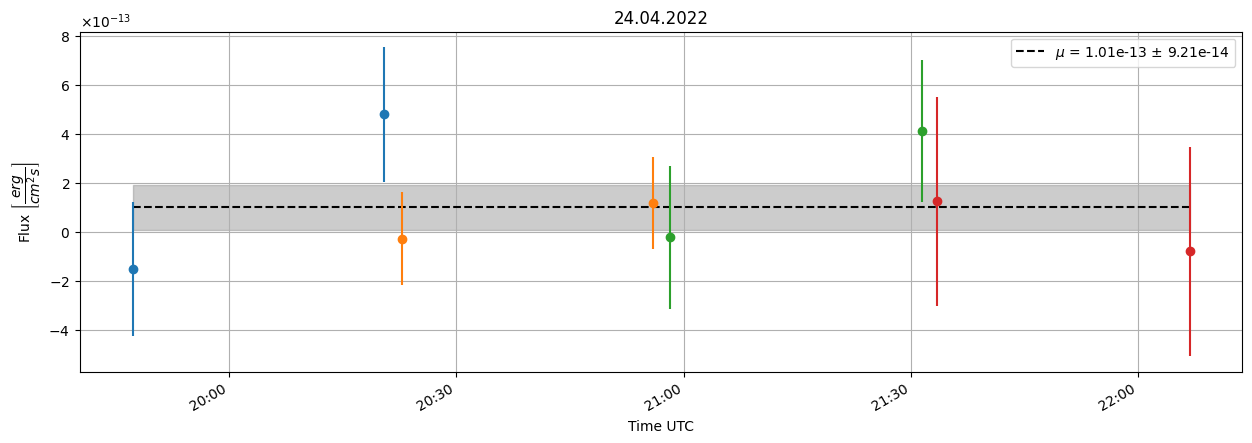

In [45]:
plt.figure(figsize=(15,5))
plt.gca().fill_between(date_array, opti_mean_flux+opti_mean_error, opti_mean_flux-opti_mean_error, color='gray', alpha=0.4)
plt.plot(date_array, opti_mean_flux*np.ones(len(date_array)), color='black', linestyle='--',label=f'$\mu$ = {opti_mean_flux:.2e} $\pm$ {opti_mean_error:.2e}')
print(opti_times,'\n',opti_flux,'\n',opti_errors)
for i in range(len(opti_times)):
    dates = matplotlib.dates.date2num(opti_times[i])
    plt.errorbar(dates,factor * opti_flux[i],yerr=[float(x)*factor for x in opti_errors[i]],fmt='o')
plt.xlabel('Time UTC')
date_fmt = matplotlib.dates.DateFormatter('%H:%M')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gcf().autofmt_xdate()
#grid
plt.grid(True,which='both')
plt.ylabel(r'Flux $\left[\dfrac{erg}{cm^2 s}\right]$')
plt.title('24.04.2022')
plt.legend()
#plt.savefig('../figures/2404/lc_2404_notconst.png',dpi=500)

#### 24.04 constant flux

In [47]:
opti_flux = []
opti_times = []
opti_errors = []

for scw_test,coord_test in zip(fits_data.keys(),coord_list):

    if scw_test == '249500280010' or scw_test == '249500230010':
        continue

    wcs = WCS(fits_data[str(scw_test)][2].header)
    row = table[table['SCW_ID'] == scw_test]

    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_start = datetime.strptime(t_start,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    t_end = datetime.strptime(t_end,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    flux_times =[t_start, t_end]
    opti_times.append(flux_times)

    data_test = fits_data[str(scw_test)][2].data
    x_start,y_start = wcs.wcs_world2pix(coord_test[0].ra.deg,coord_test[0].dec.deg,1)
    x_end,y_end = wcs.wcs_world2pix(coord_test[1].ra.deg,coord_test[1].dec.deg,1)
    x_start,x_end,y_start,y_end = int(np.round(x_start)),int(np.round(x_end)),int(np.round(y_start)),int(np.round(y_end))
    delta = 10
    data_test = data_test[y_start-delta:y_start+delta,x_start-delta:x_start+delta] #we take a square of 20x20 pixels around the source initial position
    data_test = np.nan_to_num(data_test)
    if np.sum(data_test) != 0:
        x_data= np.arange(data_test.shape[1])
        y_data = np.arange(data_test.shape[0])

        x_data, y_data = np.meshgrid(x_data, y_data)
        z_data = data_test.flatten()

        #initial guess at center of image
        initial_guess = (0, 1e-4)

        # Fit the Gaussian to the data with fixed centers
        result = minimize(objective_const,initial_guess, args=((x_data,y_data), z_data, x_data.shape[0]/2, y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)))
        offset,h = result.x
        fit = sum_gaussian_2d_const((x_data, y_data), offset,h,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)).reshape(data_test.shape)
        residual = data_test - fit
        x,y = np.meshgrid(np.linspace(0,20,100),np.linspace(0,20,100))
        fit_smooth = sum_gaussian_2d_const((x, y), offset,h,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start)).reshape(x.shape)

        opti_flux.append(np.array([h,h]))

        h_const = np.array([h,h])
        opti_error = []
        for i in range(len(h_const)):
            best_fit = h_const[i]
            amplitude_range = 1.5*best_fit
            num_steps = 11
            amplitude_values = np.linspace(best_fit-amplitude_range/2,best_fit+amplitude_range/2,num_steps)
            chi_square_values = np.zeros_like(amplitude_values)
            for k, amplitude in enumerate(amplitude_values):
            # Fit the model with the fixed amplitude
            # Calculate the residuals between the model predictions and observed data
            # Calculate the chi-square value
                model_fit = sum_gaussian_2d_const((x_data,y_data), offset, amplitude,x_data.shape[0]/2,y_data.shape[0]/2,x_data.shape[0]/2+(x_end-x_start),y_data.shape[0]/2+(y_end-y_start))
                residuals = data_test.ravel() - model_fit
                chi_square = np.sum(residuals**2)
                chi_square_values[k] = chi_square
            best_fit_chi_square = np.sum(residual**2)
            deviations = (chi_square_values - best_fit_chi_square)/best_fit_chi_square*100
            popt, pcov = curve_fit(dev_fit, amplitude_values, deviations)
            amp = np.linspace(-0.02,0.02,10000)
            dev = dev_fit(amp,*popt)

            #find for which amp, we cross the 2% threshold
            for j in range(len(dev)):
                if dev[j] < threshold:
                    amplitude_uncertainty = np.abs(amp[j]-best_fit)
                    break
            opti_error.append(amplitude_uncertainty)

        opti_errors.append(opti_error)

        # fig,ax = plt.subplots(1,2,figsize=(14,7))
        # # Title for the figure
        # fig.suptitle('SCW : '+str(scw_test))
        # im1=ax[0].imshow(data_test, cmap='viridis')
        # im1b=ax[0].contour(fit, levels = 3,colors='black')
        # # Create Line2D objects for the legend
        # legend_elements = [
        #     Line2D([0], [0], color='black', label=r'Fit'),
        # ]
        # ax[0].legend(handles=legend_elements)
        # im2=ax[1].imshow(fit_smooth, cmap='viridis')
        # ax[0].set_title('Data')
        # ax[1].set_title('Model')
        # cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.04, pad=0.04)
        # cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.04, pad=0.04)
        # plt.tight_layout()
        # plt.show()

In [49]:
opti_flux_ur = np.array([item for sublist in opti_flux for item in sublist])
opti_errors_ur = np.array([item for sublist in opti_errors for item in sublist])
opti_mean_flux= sum([x/y/y for x,y in zip(opti_flux_ur,opti_errors_ur)])/sum([1/y/y for y in opti_errors_ur])
opti_mean_error = np.sqrt(1/sum([1/y/y for y in opti_errors_ur]))
opti_times_ur = [item for sublist in opti_times for item in sublist]
earliest_date = datetime.fromisoformat(str(min(opti_times_ur)))
latest_date = datetime.fromisoformat(str(max(opti_times_ur)))
date_array= np.linspace(0, 1, 10)
date_array = [(latest_date - earliest_date) * x + earliest_date for x in date_array]
opti_mean_flux = opti_mean_flux * factor
opti_mean_error = opti_mean_error * factor

weighted_mean = sum(opti_flux_ur / opti_errors_ur**2) / sum(1 / opti_errors_ur**2)
weighted_error = np.sqrt(1 / sum(1 / opti_errors_ur**2))

[array([0.00045484, 0.00045484]), array([0.00012509, 0.00012509]), array([0.00053885, 0.00053885]), array([6.61914994e-05, 6.61914994e-05])]
[[datetime.datetime(2022, 4, 24, 19, 47, 17, tzinfo=<UTC>), datetime.datetime(2022, 4, 24, 20, 20, 27, tzinfo=<UTC>)], [datetime.datetime(2022, 4, 24, 20, 22, 48, tzinfo=<UTC>), datetime.datetime(2022, 4, 24, 20, 55, 58, tzinfo=<UTC>)], [datetime.datetime(2022, 4, 24, 20, 58, 10, tzinfo=<UTC>), datetime.datetime(2022, 4, 24, 21, 31, 29, tzinfo=<UTC>)], [datetime.datetime(2022, 4, 24, 21, 33, 27, tzinfo=<UTC>), datetime.datetime(2022, 4, 24, 22, 6, 47, tzinfo=<UTC>)]]


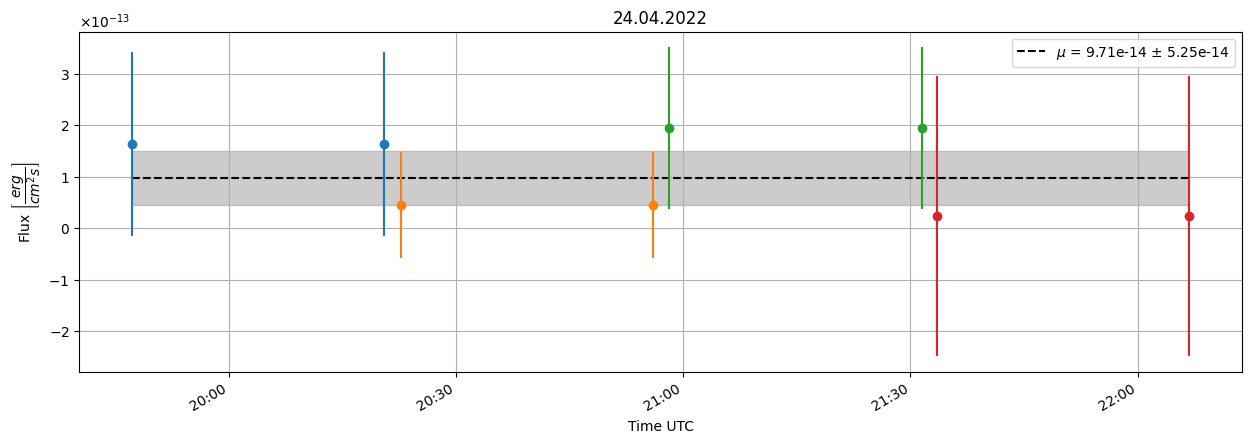

In [50]:
plt.figure(figsize=(15,5))
plt.gca().fill_between(date_array, opti_mean_flux+opti_mean_error, opti_mean_flux-opti_mean_error, color='gray', alpha=0.4)
plt.plot(date_array, opti_mean_flux*np.ones(len(date_array)), color='black', linestyle='--',label=f'$\mu$ = {opti_mean_flux:.2e} $\pm$ {opti_mean_error:.2e}')
print(opti_flux)
print(opti_times)
for i in range(len(opti_times)):
    dates = matplotlib.dates.date2num(opti_times[i])
    plt.errorbar(dates,factor * opti_flux[i],yerr=[float(x)*factor for x in opti_errors[i]],fmt='o')
plt.xlabel('Time UTC')
date_fmt = matplotlib.dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gcf().autofmt_xdate()
#grid
plt.grid(True,which='both')
plt.ylabel(r'Flux $\left[\dfrac{erg}{cm^2 s}\right]$')
plt.title('24.04.2022')
plt.legend()
#plt.savefig('../figures/2404/lc_2404_psf_const.png',dpi=500)

### Correlation with solar events and solar flux variations

In [54]:
# First let's plot the solar flux in the 1.55-12.4 keV range from GOES time series
# The data is available at https://www.ngdc.noaa.gov/stp/satellite/goes/dataaccess.html

from astropy.visualization import time_support

from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a

tstart = "2022-04-19 00:01"
tend = "2022-04-24 23:59"
result = Fido.search(a.Time(tstart, tend), a.Instrument("XRS"),a.goes.SatelliteNumber(16))

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Text(0.5, 1.05, 'GOES-16 XRS 1.5-12.4 keV flux')

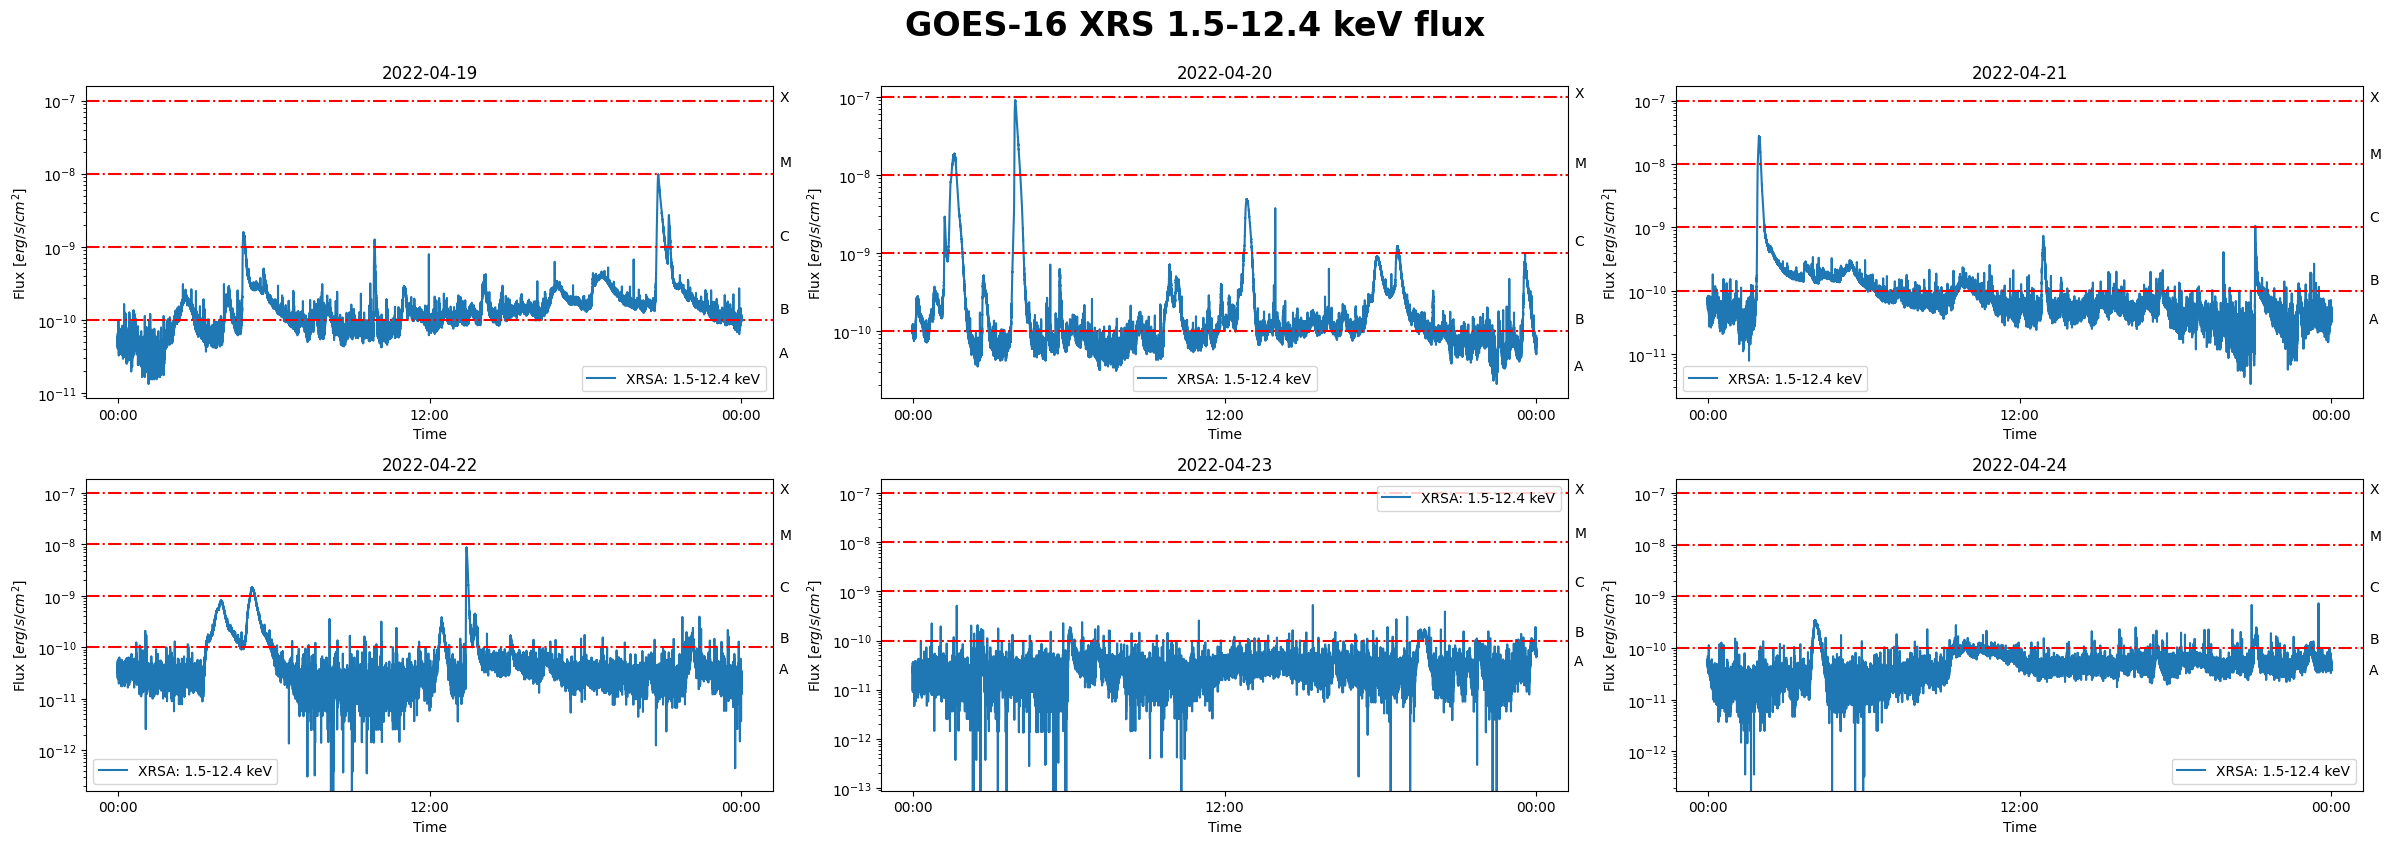

In [55]:
time_support()
fig, axes = plt.subplots(2,3,figsize=(24, 8))
axes = axes.flatten()
for i in range(len(result[0])):
    ax = axes[i]
    file = Fido.fetch(result[0][i])
    goes = ts.TimeSeries(file, source='XRS')
    ax.plot(goes.time, 1e-3*goes.quantity("xrsa"), label='XRSA: 1.5-12.4 keV')
    ax.set_xlabel('Time')
    ax.set_ylabel(r'Flux [$erg/s/cm^2$]')
    ax.set_yscale('log')
    ax.legend(loc='best')
    #Put the day in the title
    ax.set_title(goes.time[10].strftime('%Y-%m-%d'))
    #Only the hours and minutes in the x-axis
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    #put the flare classes in the plot as horizontal lines
    ax.axhline(y=1e-3*10**(-7), color='r', linestyle='-.')
    ax.axhline(y=1e-3*10**(-6), color='r', linestyle='-.')
    ax.axhline(y=1e-3*10**(-5), color='r', linestyle='-.')
    ax.axhline(y=1e-3*10**(-4), color='r', linestyle='-.')
    #put the flare classes in the plot as text on the right y axis
    ax.text(1.01, 1e-3*10**(-7.5), 'A', transform=ax.get_yaxis_transform(), color='k')
    ax.text(1.01, 1e-3*10**(-6.9), 'B', transform=ax.get_yaxis_transform(), color='k')
    ax.text(1.01, 1e-3*10**(-5.9), 'C', transform=ax.get_yaxis_transform(), color='k')
    ax.text(1.01, 1e-3*10**(-4.9), 'M', transform=ax.get_yaxis_transform(), color='k')
    ax.text(1.01, 1e-3*10**(-4), 'X', transform=ax.get_yaxis_transform(), color='k')
plt.tight_layout()
#put the title on top of the figure but high enough so it doesn't overlap with the subplots
plt.suptitle('GOES-16 XRS 1.5-12.4 keV flux', y=1.05, fontsize=24, fontweight='bold')
#plt.savefig('../figures/GOES_total.png', dpi=500)

Now let's check a zoom of the solar flux variability for both dates.

22.04

In [103]:
tstart = "2022-04-22 04:00"
tend = "2022-04-22 13:00"
result = Fido.search(a.Time(tstart, tend), a.Instrument("XRS"),a.goes.SatelliteNumber(16))
file = Fido.fetch(result[0][0])
goes = ts.TimeSeries(file, source='XRS')
goes = goes.truncate(tstart,tend)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [63]:
opti_times_22_ur_mod = []
for t in opti_times_22_ur:
    opti_times_22_ur_mod.append(t-timedelta(minutes=5.6))
opti_times_22_ur_mod = [mdates.date2num(t) for t in opti_times_22_ur]

datetimes = [datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f') for dt_str in goes.time.iso]

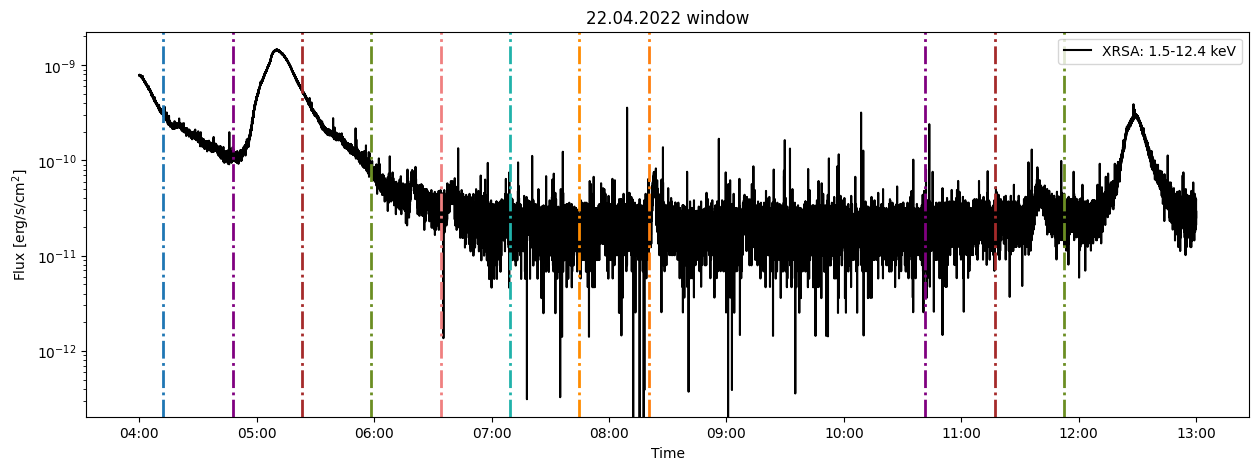

In [64]:
time_support()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(datetimes, 1e-3*goes.quantity("xrsa"),color = 'k', label='XRSA: 1.5-12.4 keV')
#print a vertical line for each time in the optimal times list
ax.set_ylabel(r"Flux [erg/s/cm$^2$]")
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
colors = ['tab:blue','purple','brown','olivedrab','lightcoral','lightseagreen','darkorange','tab:orange','purple','brown','olivedrab']
for t,color in zip(opti_times_22_ur_mod[::2],colors):
    ax.axvline(x=t, linestyle='-.',linewidth=2,color=color)
ax.set_yscale('log')
ax.set_title('22.04.2022 window')
ax.legend(loc='best')
#plt.savefig('../figures/GOES_22.png', dpi=500)
plt.show()

24.04

In [154]:
tstart = "2022-04-24 19:45"
tend = "2022-04-24 22:00"
result = Fido.search(a.Time(tstart, tend), a.Instrument("XRS"),a.goes.SatelliteNumber(16))
file = Fido.fetch(result[0][0])
goes = ts.TimeSeries(file, source='XRS')
goes_24 = goes.truncate(tstart,tend)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [89]:
opti_times_ur_mod = []
for t in opti_times_ur:
    opti_times_ur_mod.append(t-timedelta(minutes=5.6))
opti_times_ur_mod = [mdates.date2num(t) for t in opti_times_ur]

datetimes = [datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f') for dt_str in goes_24.time.iso]

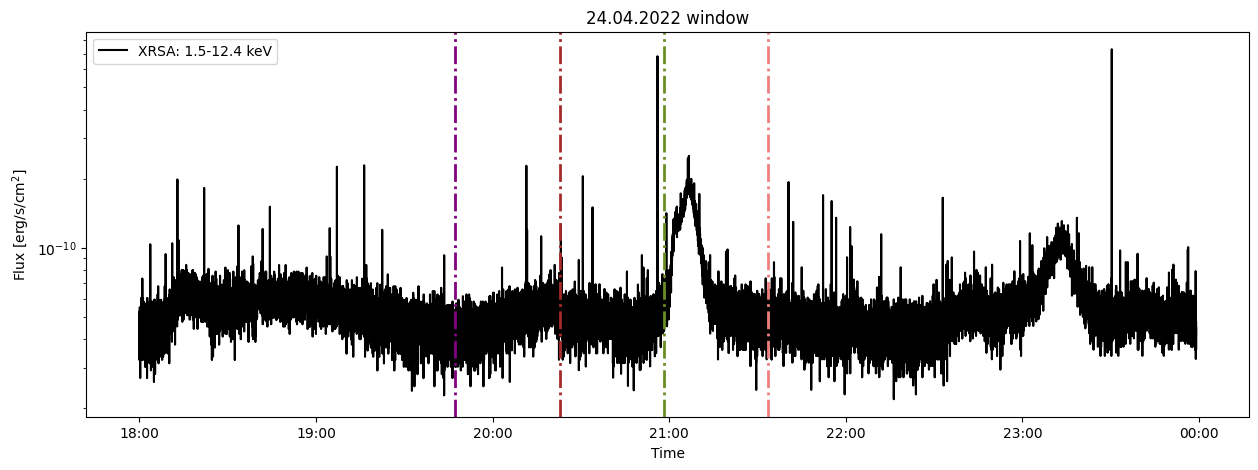

In [90]:
time_support()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(datetimes, 1e-3*goes_24.quantity("xrsa"),color = 'k', label='XRSA: 1.5-12.4 keV')
#print a vertical line for each time in the optimal times list
ax.set_ylabel(r"Flux [erg/s/cm$^2$]")
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
colors = ['purple','brown','olivedrab','lightcoral']
for t,color in zip(opti_times_ur_mod[::2],colors):
    ax.axvline(x=t, linestyle='-.',linewidth=2,color=color)
ax.set_yscale('log')
ax.set_title('24.04.2022 window')
ax.legend(loc='best')
#plt.savefig('../figures/GOES_24.png', dpi=500)
plt.show()

#### Overplot of the normalised Venus and Solar fluxes.

Now let's try to overplot both fluxes to see if there is a time correlation between solar flares and Venus' increase in X-ray fluxes.

22.04

In [134]:
unraveled_fluxes_22 = [item for sublist in lc_fluxes_220422 for item in sublist]
unraveled_errors_22 = [item for sublist in lc_errors_220422 for item in sublist]
mean_flux_22= sum([x/y/y for x,y in zip(unraveled_fluxes_22,unraveled_errors_22)])/sum([1/y/y for y in unraveled_errors_22])
mean_error_22 = np.sqrt(1/sum([1/y/y for y in unraveled_errors_22]))
unraveled_times_22 = [item for sublist in lc_times_220422 for item in sublist]
unraveled_time_errors_22 = [item for sublist in time_errors_220422 for item in sublist]

In [143]:
sf_2204 = []#preprocessing.normalize([1e-3*goes.quantity("xrsa").value])
vf_2204 = []
vf_2204_err = []
for flux in unraveled_fluxes_22:
    vf_2204.append((flux-mean_flux_22)/mean_error_22)
for error in unraveled_errors_22:
    vf_2204_err.append(error/mean_error_22)
for flux in goes.quantity("xrsa").value:
    sf_2204.append((flux-np.mean(goes.quantity("xrsa").value))/np.std(goes.quantity("xrsa").value))
times_22 = []
for t in unraveled_times_22:
    times_22.append(t-timedelta(minutes=5.6))
times_22 = [mdates.date2num(t) for t in times_22]
datetimes = [datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f') for dt_str in goes.time.iso]


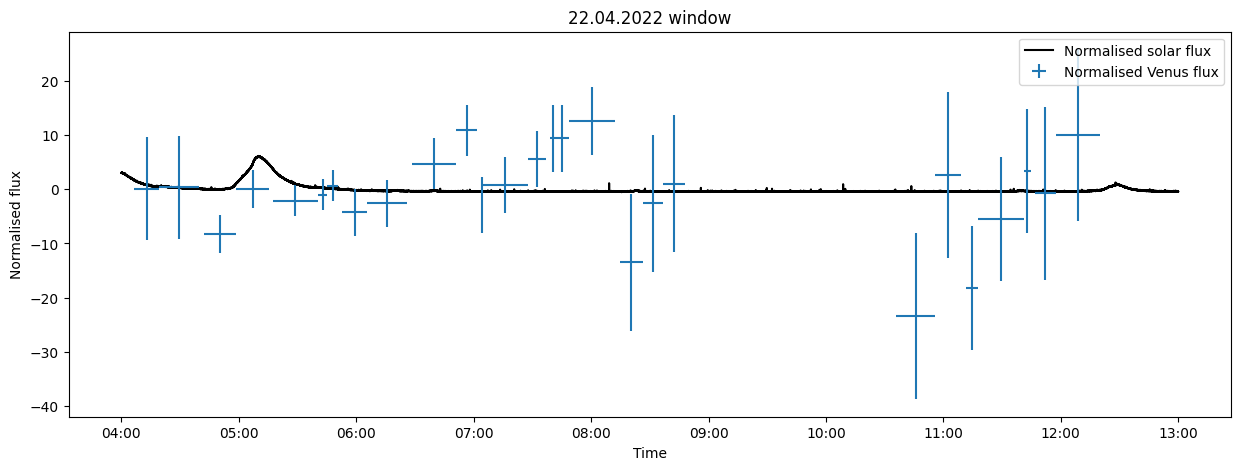

In [144]:
time_support()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(datetimes, sf_2204,color = 'k', label='Normalised solar flux')
#print a vertical line for each time in the optimal times list
ax.set_ylabel(r"Normalised flux")
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
ax.errorbar(times_22, vf_2204,yerr=vf_2204_err,xerr=unraveled_time_errors_22, color='tab:blue', label='Normalised Venus flux',fmt=' ')
#ax.set_yscale('log')
ax.set_title('22.04.2022 window')
#y limits on the first set of points
ax.legend(loc='best')
plt.show()

In [140]:
#do a ks test
from scipy.stats import ks_2samp
ks_2samp(sf_2204,vf_2204)
print('KS test for 22.04.2022 window: ',ks_2samp(sf_2204,vf_2204))


KS test for 22.04.2022 window:  KstestResult(statistic=0.4444444444444444, pvalue=2.2233364636971857e-05, statistic_location=-0.770906049568307, statistic_sign=-1)


24.04

In [146]:
unraveled_fluxes = [item for sublist in lc_fluxes for item in sublist]
unraveled_errors = [item for sublist in lc_errors for item in sublist]
mean_flux= sum([x/y/y for x,y in zip(unraveled_fluxes,unraveled_errors)])/sum([1/y/y for y in unraveled_errors])
mean_error = np.sqrt(1/sum([1/y/y for y in unraveled_errors]))
unraveled_times = [item for sublist in lc_times for item in sublist]
unraveled_time_errors = [item for sublist in time_errors for item in sublist]

In [155]:
sf = []#preprocessing.normalize([1e-3*goes.quantity("xrsa").value])
vf = []
vf_err = []
for flux in unraveled_fluxes:
    vf.append((flux-mean_flux)/mean_error)
for error in unraveled_errors:
    vf_err.append(error/mean_error)
for flux in goes_24.quantity("xrsa").value:
    sf.append((flux-np.mean(goes_24.quantity("xrsa").value))/np.std(goes_24.quantity("xrsa").value))
times_24 = []
for t in unraveled_times:
    times_24.append(t-timedelta(minutes=5.6))
times_24 = [mdates.date2num(t) for t in times_24]
datetimes = [datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f') for dt_str in goes_24.time.iso]

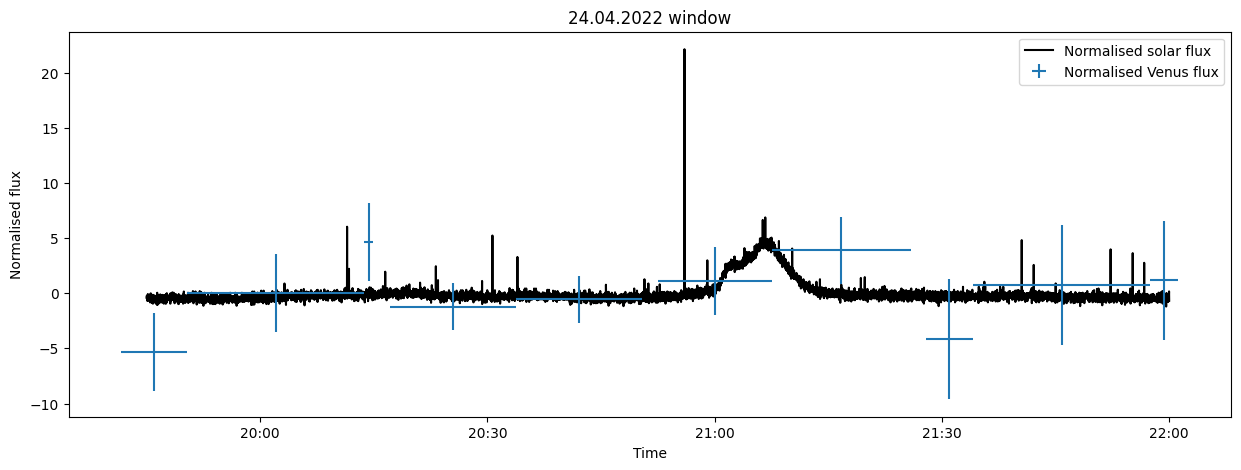

In [156]:
time_support()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(datetimes, sf,color = 'k', label='Normalised solar flux')
#print a vertical line for each time in the optimal times list
ax.set_ylabel(r"Normalised flux")
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
ax.errorbar(times_24, vf,yerr=vf_err,xerr=unraveled_time_errors, color='tab:blue', label='Normalised Venus flux',fmt=' ')
#ax.set_yscale('log')
ax.set_title('24.04.2022 window')
#y limits on the first set of points
ax.legend(loc='best')
plt.show()

In [162]:
#ks test
print('KS test for 24.04.2022 window: ',ks_2samp(sf,vf))

KS test for 24.04.2022 window:  KstestResult(statistic=0.41172839506172837, pvalue=0.048048668651091815, statistic_location=0.7338982224464417, statistic_sign=1)
